In [2]:
# Preparations
import os
from PIL import Image
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from itertools import compress
from pyflann import *

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2
#from scipy.misc import imresize, imsave
from scipy import sparse

from skimage.transform import resize, rotate, SimilarityTransform
from skimage.io import imread
from skimage.measure import ransac
from skimage.color import rgb2gray

from utils import findNeighbours, kdtreequery, matchWords, plotMatches, geometricVerification, getHistogramFromDescriptor, plotRetrievedImages, plotFrameBoth

import time

# Select data directory
if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-07-data')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-07-data


In [ ]:
# Description:
#    Exercise7 VGG practical notebook (Part3, fast track).
#
# This software is inspired by original object instance recognition
# VGG practical. 
# Licence; please refer to the file 
# Licence.txt, included with the software, for details.

In [3]:
%load_ext line_profiler

# CS-E4850 Computer Vision Exercise Round 7

This is a minimal python version of Oxford Visual Geometry Group's Matlab practical on recognition of object instances (see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part3>here</a>). By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources. All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>. The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. <br><br>

This notebook is <b>the third part (PART III)</b> of the practical on the so-called <em>fast-track</em> and demonstrates the operation of <b>a large scale image retriaval system</b>.
<br><br>
Go through the notebook and answer the questions. You can write your answers to a separate text document and submit that as you are not supposed to implement anything in this exercise.

**NOTE TO DOCKER USERS:**

Git has a filesize limit and therefore two data files can't be shared through git and you have to manually download the files(size ~95MB and ~150MB). This does not concern JupyterHub. Download the following files into the folder 'coursedata/exercise-07-data/data_part3/' <br>

[imdb.npy](https://drive.google.com/open?id=1P8TjRIdwYtJHpm3l88v-8Gm1DbZSj-5P) <br>(checksum 1132d7d850fba611436eb74b43fd715b) <br> 
[sift_disc_vocab.npy](https://drive.google.com/open?id=1pMOcLj5AT4DiSzzUfejoTOZr5b1kp7aZ) <br> (checksum e6264c5b7c59d735ce92947add7cd636)<br>

## Part III: Towards large scale retrieval

In large scale retrieval the goal is to match a query image to a large database of images (for example the WWW or Wikipedia). The quality of a match is measured as the number of geometrically verified feature correspondences between the query and a database image. While the techniques discussed in Part I and II are sufficient to do this, in practice they require too much memory to store the SIFT descriptors for all the detections in all the database images. We explore next two key ideas: one to reduce the memory footprint and pre-compute descriptor matches; the other to speed up image retrieval.

Task: Examine and run the python code lines below.

In [4]:
## -------------------------------------------------------------------
#      Preparations
# --------------------------------------------------------------------

# Load images (rgb2gray is used here just to easen plotting)
im1 = imread(data_dir+'/data/oxbuild_lite/ashmolean_000007.jpg') / 255.
im2 = imread(data_dir+'/data/oxbuild_lite/ashmolean_000028.jpg') / 255.

## Load precomputed data 
# SIFT feature points and descriptors for im1 and im2, and quantized descriptors' word vocabulary
data1=np.load(data_dir+"/data_part3/img1_sift_kps_descs.npy", encoding='latin1', allow_pickle=True)
kps1 = data1.item().get('keypoints')
descrs1 = data1.item().get('descriptors')

data2=np.load(data_dir+"/data_part3/img2_sift_kps_descs.npy", encoding='latin1', allow_pickle=True)
kps2 = data2.item().get('keypoints')
descrs2 = data2.item().get('descriptors')

# REMEMBER TO DOWNLOAD THE FILE USING THE GDRIVE LINK 
vocab = np.load(data_dir+"/data_part3/sift_disc_vocab.npy", encoding='latin1', allow_pickle=True)

# Get the matches based on the raw descriptors
tic = time.clock()
#%lprun -f findNeighbours findNeighbours(descrs1, descrs2, numNeighbors=2)
ind, dist = findNeighbours(descrs1, descrs2, numNeighbors=2)
nnThreshold = 0.85
ratio2 = np.divide(dist[:,0], dist[:,1])
ok = ratio2 <= nnThreshold ** 2
matches_raw = np.vstack((np.nonzero(ok), ind[ok, 0]))
matches_raw = matches_raw.T
time_raw = time.clock()-tic

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### Stage III.A: Accelerating descriptor matching with visual words
Instead of matching feature descriptors directly as done in Part I and II, descriptors are usually mapped first to discrete symbols, also called visual words, by means of a clustering technique like K-Means. The descriptors that are assigned to the same visual word are considered matched. Each of the rows in the following figure illustrates image patches that are mapped to the same visual word, and are hence indistinguishable by the representation.

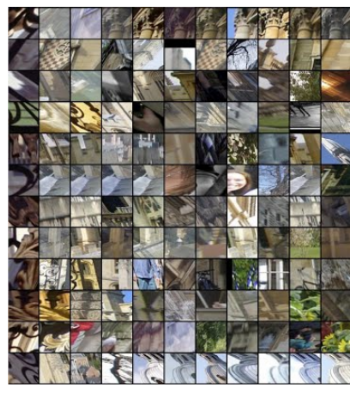

In [5]:
imvw = imread(data_dir+'/data/visualwords.png')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.imshow(imvw)
ax.axis('off')
plt.show()

Then, matching two sets of feature descriptors (from two images) reduces to finding the intersection of two sets of symbols.

Tasks:
- Load a visual word dictionary (should be done already) and familiarize yourself with the associated approximate nearest neighbour (ANN) matcher inside the kdtreequery function <br>(the ANN matcher is used to determine the closest visual word to each descriptor and is based on a forest of KD trees).
- Given SIFT descriptors for two images, quantise them (assign them) into the corresponding visual words.
- Find corresponding features by looking for the same visual words in the two images and note the computation time.
- Geometrically verify these initial correspondences and count the number of inlier matches found.
- Find corresponding features by using the method of Part I and II, i.e. by comparing the descriptors directly, <br>
and note the computation time. Geometrically verify these initial correspondences and count the number of inlier matches found.
- Compare the speed and number of inliers when using visual words vs raw SIFT descriptors by means of the function matchWords. <br>Note, you should repeat the timing (by running the matching again) <br>as the first time you run it there may be a delay as a result of running the code using jupyter notebooks.
- Optional: compare the speed and number of matches over another pair of images (from part I and II).

In [11]:
## -------------------------------------------------------------------
#      Stage III.a: Accelerating descriptor matching with visual words
# --------------------------------------------------------------------

# Quantise the descriptors

words1 = kdtreequery(vocab, descrs1, maxNumChecks=1024)
words2 = kdtreequery(vocab, descrs2, maxNumChecks=1024)

# Get the matches based on quantized descriptors
tic = time.clock()
#%lprun -f matchWords matchWords(words1, words2)
matches_word = matchWords(words1, words2)
time_word = time.clock()-tic

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(32,16))
ax = axes.ravel()
plotFrameBoth(ax[0], im1, im2, kps1, kps2, matches_raw, plotMatches=True)
ax[0].set_title("Matches on raw descriptors ({} matches in {} seconds)".format(len(matches_raw), time_raw))
plotFrameBoth(ax[1], im1, im2, kps1, kps2, matches_word, plotMatches=True)
ax[1].set_title("Matches on quantized descriptors ({} matches in {} seconds)".format(len(matches_word), time_word))
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


8.536639000000001


In [7]:
# Count inliers, i.e. perform geometric verification
inliers_raw, H_raw = geometricVerification(kps1, kps2, matches_raw, 3)
inliers_word, H_word = geometricVerification(kps1, kps2, matches_word, 3)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(32,16))
ax = axes.ravel()
plotFrameBoth(ax[0], im1, im2, kps1, kps2, matches_raw[inliers_raw,:], plotMatches=True)
ax[0].set_title("Verified matches on raw descriptors ({} matches)".format(len(matches_raw[inliers_raw,:])))
plotFrameBoth(ax[1], im1, im2, kps1, kps2, matches_word[inliers_word,:], plotMatches=True)
ax[1].set_title("Verified matches on quantized descriptors ({} matches)".format(len(matches_word[inliers_word,:])))
plt.show()

<b>Questions</b>:
- The size of the vocabulary (the number of clusters) is an important parameter in visual word algorithms. How does the size affect the number of inliers and the difficulty of computing the transformation?
- In the above procedure the time required to convert the descriptors into visual words was not accounted for. Why?
- What is the speedup in searching a large, fixed database of 10, 100, 1000 images? 

Hint: You may use the lineprofiler (commented lines) to better see what is happening behind the curtains (uncomment and compare Total times). The timings reported in the titles of the plots are not very truthful, but there is a difference between those numbers as well). 

### Step III.b: Searching with an inverted index
While matching with visual words is much faster than doing so by comparing feature descriptors directly, scoring images directly based on the number of geometrically verified matches still entails fitting a geometric model, a relatively slow operation. Rather than scoring all the images in the database in this way, we are going to use an approximation and count the number of visual words shared between two images.

To this end, one computes a histogram of the visual words in a query image and for each of the database images. Then the number of visual words in common can be computed from the intersection of the two histograms.

The histogram intersection can be thought as a similarity measure between two histograms. In practice, this measure can be refined in several ways:
- By reducing the importance of common visual words. This is similar to a stop-words list and can be implemented by weighting each word by the `inverse document frequency' (the inverse of the frequency of occurrence of that visual word over the entire database of images).
- By normalising the weighted histograms to unit vectors and using the cosine between them as similarity. This can be implemented easily as the inner product between normalised histograms.

Computing histogram similarities can be implemented extremely efficiently using an inverted file index. In this exercise, inner products between normalized histograms are computed quite efficiently using scipy's built-in sparse matrix engine.

We now apply this retrieval method to search using a query image within a 660 image subset of the Oxford 5k building image set.

<b>IMPORTANT NOTE</b> (after you have run the lines in the cell below):The top image does not have here (in this python practical) a score of 1 (but ~0.97 instead). This is because the computations for the database images were entirely (including descriptor quantization) done in Matlab using the VLfeat library. For the query, in turn, the words are generated using a pyflann-based implementation (check utils.py). The difference in scores reflects the fact that the given descriptor quantization methods (here and the one in the matlab practical) produce both a bit different quantization result with the same vocabulary and descriptors. If the words of the database images were generated in a similar manner than for the query the top score would be 1 (as it is the same image), or other way around, it would be 1 if the words for the query were also generated using the matlab version. Now, your task is just to pretend that the score was 1 (like it should be in reality) and answer the question. <em>If you want to compare the generated short-list here to the one generated by the original practical in Matlab (see ./data/retrieval-shortlist.png), you'll see that it contains the same images but with a bit varying ordering, the most strongly matching being the same.</em>


In [8]:
## -------------------------------------------------------------------
#                        Stage III.B: Searching with an inverted index
# --------------------------------------------------------------------

# We are using im2 as the query.

## Load precomputed data 
# SIFT feature points and descriptors for im2 (note that we are using affine robust SIFT features)
data2 = np.load(data_dir+"/data_part3/img2_sift_ellipse_kps_descs.npy", encoding='latin1', allow_pickle=True)
kps2 = data2.item().get('keypoints')
descrs2 = data2.item().get('descriptors')

# Load all imdb related resources
data = np.load(data_dir+"/data_part3/imdb.npy", encoding='latin1', allow_pickle=True)

index = data.item().get('index') # all sift feature histograms of the database images
vocab = data.item().get('vocabulary') # visual word vocabulary (ellipse)
idf = data.item().get('idf') # inverse document frequency 
imdbImDir = str.encode(data_dir+'/')+data.item().get('imdir') # imgfile information
imdbImNames = data.item().get('imnames')
imdbImWords = data.item().get('imwords') # quantized sift descriptors
imdbImKps = data.item().get('imkps') # keypoint frames of database images

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


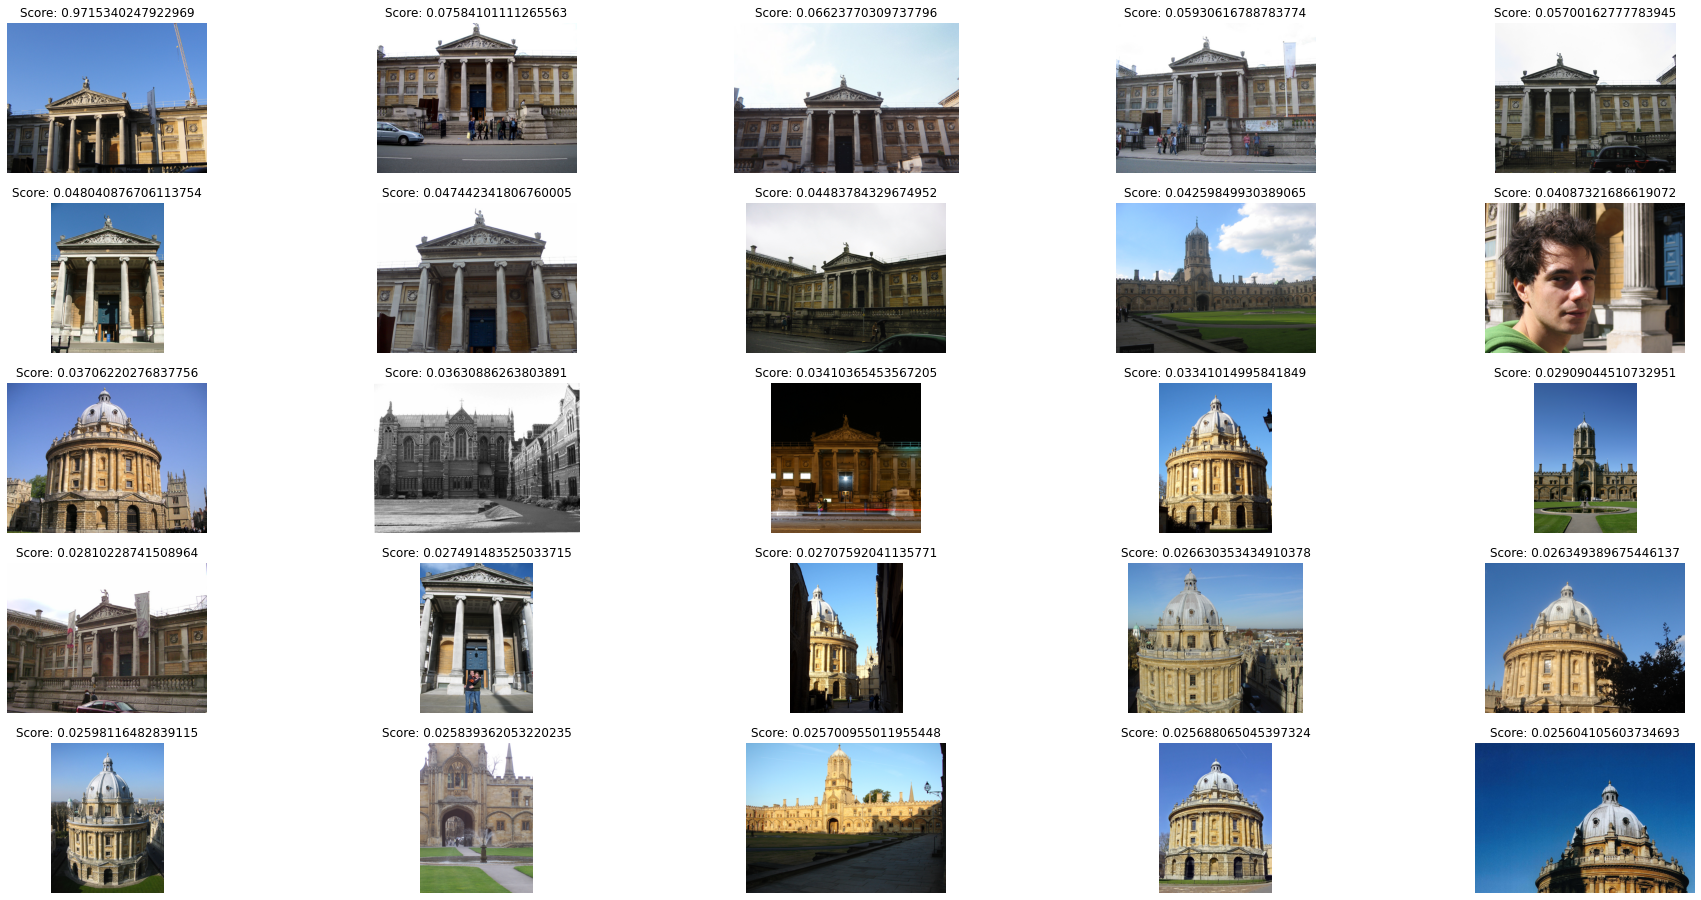

In [9]:
h = getHistogramFromDescriptor(vocab, idf, descrs2)

# Score the other images by similarity to the query
tic = time.clock()
scores = index.dot(h)
time_index = time.clock() - tic
scores = scores.squeeze()

plotRetrievedImages(imdbImDir, imdbImNames, scores, 25)

# CS-E4850 Computer Vision Exercise Round 7

This is a minimal python version of Oxford Visual Geometry Group's Matlab practical on recognition of object instances (see the original webpage <a href= http://www.robots.ox.ac.uk/~vgg/practicals/instance-recognition/index.html#part3>here</a>). By "minimal" it is meant that it uses pre-computed SIFT features and some other needed resources. All of them are calculated using the freely available matlab scripts found in the practical's github <a href=https://github.com/vedaldi/practical-object-instance-recognition >repository</a>. The practical is largely based on the vlfeat library (cf. http://www.vlfeat.org/) which unfortunately does not have a Python interface. 
<br><br> 
This notebook is <b>the first part (PART I)</b> of the practical on the so-called  <em> fast track</em> and is about <b>sparse features for matching object instances</b>.
<br><br>
Go through the notebook and answer the questions. You can write your answers to a separate text document and submit that as you are not supposed to implement anything in this exercise.

Task: How many erroneously matched images do you count in the top results? <br> <b>Question</b>: Why does the top image have a score of 1 (0.9698... see the NOTE above)?

### Stage III.C: Geometric rescoring
Histogram-based retrieval results are good but far from perfect. Given a short list of top ranked images from the previous step, we are now going to re-score them based on the number of inlier matches after a geometric verification step.

In [10]:
## -------------------------------------------------------------------
#                                    Stage III.C: Geometric reranking
# --------------------------------------------------------------------
# Rescore the top 25 images based on the number of
# inlier matches.
sorted_scores = np.sort(scores, axis=0)
id_sorted_scores = np.argsort(scores, axis=0)
sorted_scores = sorted_scores[::-1]
id_sorted_scores = id_sorted_scores[::-1]

words = kdtreequery(vocab, descrs2, maxNumChecks=1024)

for rank in range(25):
    ii = id_sorted_scores[rank]
    db_instance_words = imdbImWords[ii]
    matches = matchWords(words, db_instance_words)
    instance_kps = imdbImKps[ii].T
    inliers_word, H_word = geometricVerification(kps2, instance_kps, matches, 3)
    newScore = len(inliers_word)
    scores[id_sorted_scores[rank]] = newScore

# Plot results by decreasing score
plotRetrievedImages(imdbImDir, imdbImNames, scores, 25)

<b>Question</b>: Why is the top score much larger than 1 now?<br> <b>Question</b>: Are the retrieval results improved after geometric verification?

### Stage III.D: Full system
Now try the full system to retrieve matches to an unseen query image:

In [ ]:
# Load query image
query = imread(data_dir+'/data/queries/mistery-building1.jpg') / 255.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(query)
ax.axis('off')
plt.show()

In [ ]:
## Load precomputed data 
# SIFT feature points and descriptors for the query (mistery building)
data = np.load(data_dir+"/data_part3/mistery-building1_sift_ellipse_kps_descs.npy", encoding='latin1', allow_pickle=True)

kpsq = data.item().get('keypoints')
descrsq = data.item().get('descriptors')

# imdb index
data = np.load(data_dir+"/data_part3/imdb.npy", encoding='latin1', allow_pickle=True)

index = data.item().get('index') # all sift feature histograms of the database images
vocab = data.item().get('vocabulary') # visual word vocabulary (ellipse)
idf = data.item().get('idf') # inverse document frequency 
imdbImDir = str.encode(data_dir+'/') + data.item().get('imdir') # imgfile information
imdbImNames = data.item().get('imnames')
imdbImWords = data.item().get('imwords') # quantized sift descriptors
imdbImKps = data.item().get('imkps') # keypoint frames of database images

# histogram descriptor of the query image
h = getHistogramFromDescriptor(vocab, idf, descrsq)

# Score the other images by similarity to the query
tic = time.clock()
scores = index.dot(h)
time_index = time.clock() - tic
scores = scores.squeeze()

# Rescore the top 25 images based on the number of inlier matches.
sorted_scores = np.sort(scores, axis=0)
id_sorted_scores = np.argsort(scores, axis=0)
sorted_scores = sorted_scores[::-1]
id_sorted_scores = id_sorted_scores[::-1]

words = kdtreequery(vocab, descrsq, maxNumChecks=1024)

for rank in range(25):
    ii = id_sorted_scores[rank]
    db_instance_words = imdbImWords[ii]
    matches = matchWords(words, db_instance_words)
    instance_kps = imdbImKps[ii].T
    inliers_word, H_word = geometricVerification(kpsq, instance_kps, matches, 3)
    newScore = len(inliers_word)
    scores[id_sorted_scores[rank]] = newScore

# Plot results by decreasing score
plotRetrievedImages(imdbImDir, imdbImNames, scores, 25)